# Install required libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import json
from trad_ml_02_training_and_eval_func import tune_best_params, print_train_test_accuracy_comparison
from util_model_evaluation import get_model_evaluation

### Reading in of data (with and without fuzz features)

In [2]:
df_train = pd.read_csv("data/original_train_data.csv")
df_test = pd.read_csv("data/original_test_data.csv")

X_temp, y_temp = df_train.drop(['id1', 'id2', 'is_duplicate'], axis = 1), df_train['is_duplicate']

X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size = 0.2, 
    random_state = 42,
    stratify = y_temp
)

X_test, y_test = df_test.drop(['id1', 'id2', 'is_duplicate'], axis = 1), df_test['is_duplicate']

In [3]:
df_train_with_fuzz = pd.read_csv("data/train_data_with_fuzz_features.csv")
df_test_with_fuzz = pd.read_csv("data/test_data_with_fuzz_features.csv")

X_temp_with_fuzz, y_temp_with_fuzz = df_train_with_fuzz.drop(['id1', 'id2', 'is_duplicate'], axis = 1), df_train_with_fuzz['is_duplicate']
X_train_with_fuzz, X_val_with_fuzz, y_train_with_fuzz, y_val_with_fuzz = train_test_split(
    X_temp_with_fuzz,
    y_temp_with_fuzz,
    test_size = 0.2, 
    random_state = 42,
    stratify = y_temp_with_fuzz
)

X_test_with_fuzz, y_test_with_fuzz = df_test_with_fuzz.drop(['id1', 'id2', 'is_duplicate'], axis = 1), df_test_with_fuzz['is_duplicate']

### Initialise base models and test base performance on version 1 dataset

Final approach is to put top 3 models into a VotingClassifier.

XGB, RF and KNN are the top 3 models. Models generally underfitted. Can consider finding more meaningful features to improve model performance. Will leave out LR since it has very poor performance. This also somewhat suggests that the function that we are trying to approximate is non-linear in nature given that RF, XGB and KNN are universal approximators.

In [13]:
rf = RandomForestClassifier()
lr = LogisticRegression()
knn = KNeighborsClassifier()
xgb = XGBClassifier()

knn.fit(X_train, y_train)
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)
print("Accuracy of K-Nearest Neighbors: ", knn.score(X_val, y_val))
print("Accuracy of Logistic Regression: ", lr.score(X_val, y_val))
print("Accuracy of Random Forest: ", rf.score(X_val, y_val))
print("Accuracy of XGBoost: ", xgb.score(X_val, y_val))

Accuracy of K-Nearest Neighbors:  0.6843830195096311
Accuracy of Logistic Regression:  0.6657391089261974
Accuracy of Random Forest:  0.7155644188850756
Accuracy of XGBoost:  0.7060724113409393


### Initialise base models and test base performance on version 2 dataset

Fuzz features we introduced are some meaningful features to compare string similarity. This explains the improvement of general performance for all 3 models.

Note that KNN and RF are overfitted. XGBoost looks fine. We could do some hyperparameter tuning to the models before putting them into a VotingClassifier.

In [4]:
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
xgb = XGBClassifier()

knn_trained = print_train_test_accuracy_comparison(
    knn
    , 'K-Nearest Neighbors'
    , X_train_with_fuzz
    , y_train_with_fuzz
    , X_val_with_fuzz
    , y_val_with_fuzz)

print('\n')

xgb_trained = print_train_test_accuracy_comparison(
    xgb
    , 'XGBoost'
    , X_train_with_fuzz
    , y_train_with_fuzz
    , X_val_with_fuzz
    , y_val_with_fuzz)

print('\n')

rf_trained = print_train_test_accuracy_comparison(
    rf
    , 'Random Forest'
    , X_train_with_fuzz
    , y_train_with_fuzz
    , X_val_with_fuzz
    , y_val_with_fuzz)


Train accuracy of K-Nearest Neighbors:  0.8083117224427327
Test accuracy of K-Nearest Neighbors:  0.7141730822743716


Train accuracy of XGBoost:  0.7533614435946093
Test accuracy of XGBoost:  0.7393717342237888


Train accuracy of Random Forest:  0.9942143362332507
Test accuracy of Random Forest:  0.7368054911418236


### Hyperparameter tuning for KNN
- n_neighbors: reduces overfitting
- p: accounts for curse of dimensionality
- weights: assigns importance of points based on proximity

In [15]:
kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

knn_param_grid = {
    'n_neighbors': [5, 10, 15],
    'p': [1, 2],
    'weights': ['uniform', 'distance']
}

knn_best_params = tune_best_params(
    KNeighborsClassifier(n_jobs = 4)
    , knn_param_grid
    , X_train_with_fuzz
    , y_train_with_fuzz
    , 10
    , 'f1'
    , kf
).best_params_

### Hyperparameter tuning for XGBoost
Base model already has decent performance with slight overfitting. Hence, we attempt to tune the following hyperparameters:
- max_depth: how deep the tree grows
- subsample: the subsample of the dataset used to train each tree
- colsample_bytree: improve generalisation by not using all features

In [16]:
xgb_param_grid = {
    'max_depth' : [4, 6, 8],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb_best_params = tune_best_params(
    XGBClassifier()
    , xgb_param_grid
    , X_train_with_fuzz
    , y_train_with_fuzz
    , 10
    , 'f1'
    , kf
).best_params_

### Hyperparameter tuning for Random Forest

Base model is severely overfitted. Hence, we attempt to tune the following hyperparameters:
- n_estimators: Reduce variance with more trees for averaging.
- max_features: Improve generality.
- min_samples_leaf: Try to reduce how much a tree grows to reduce overfitting.
- max_depth: improve Try to reduce how much a tree grows to reduce overfitting.

In [17]:
rf_param_grid = {
    'n_estimators' : [100, 250, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 5],
    'max_depth': [5, 10, 15]
}

rf_best_params = tune_best_params(
    RandomForestClassifier(n_jobs = 4)
    , rf_param_grid
    , X_train_with_fuzz
    , y_train_with_fuzz
    , 10
    , 'f1'
    , kf
).best_params_

- KNN improved through hyperparameter tuning.
- XGBoost remained the same, suggesting that the base model was good enough.
- RF is now less overfitted but accuracy improved slightly.

Too many combination of hyperparameters for RF. Need more time to explore the optimal hyperparameters to reduce overfitting.

In [18]:
best_knn = print_train_test_accuracy_comparison(
    KNeighborsClassifier(**knn_best_params)
    , 'K-Nearest Neighbors'
    , X_train_with_fuzz
    , y_train_with_fuzz
    , X_val_with_fuzz
    , y_val_with_fuzz)

print('\n')

best_xgb = print_train_test_accuracy_comparison(
    XGBClassifier(**xgb_best_params)
    , 'XGBoost'
    , X_train_with_fuzz
    , y_train_with_fuzz
    , X_val_with_fuzz
    , y_val_with_fuzz)
print('\n')

best_rf = print_train_test_accuracy_comparison(
    RandomForestClassifier(**rf_best_params)
    , 'Random Forest'
    , X_train_with_fuzz
    , y_train_with_fuzz
    , X_val_with_fuzz
    , y_val_with_fuzz)

Train accuracy of K-Nearest Neighbors:  0.768465233842075
Test accuracy of K-Nearest Neighbors:  0.7255820424821445


Train accuracy of XGBoost:  0.7747301376269117
Test accuracy of XGBoost:  0.7391707633800204


Train accuracy of Random Forest:  0.7974863088083542
Test accuracy of Random Forest:  0.7382895835265745


### Save tuned hyperparameters

In [19]:
with open("models/knn_best_params.json", "w") as f:
    json.dump(knn_best_params, f)

with open("models/xgb_best_params.json", "w") as f:
    json.dump(xgb_best_params, f)

with open("models/rf_best_params.json", "w") as f:
    json.dump(rf_best_params, f)

### Load best models from hyperparameter tuning

In [20]:
with open("models/knn_best_params.json", "r") as f:
    loaded_best_knn_params = json.load(f)

with open("models/xgb_best_params.json", "r") as f:
    loaded_best_xgb_params = json.load(f)

with open("models/rf_best_params.json", "r") as f:
    loaded_best_rf_params = json.load(f)

loaded_best_knn = KNeighborsClassifier(**loaded_best_knn_params)
loaded_best_xgb = XGBClassifier(**loaded_best_xgb_params)
loaded_best_rf = RandomForestClassifier(**loaded_best_rf_params)

voting_clf = VotingClassifier(
    estimators=[
        ('knn', loaded_best_knn),
        ('xgb', loaded_best_xgb),
        ('rf', loaded_best_rf)
    ],
    voting='hard'
)

loaded_best_knn.fit(X_train_with_fuzz, y_train_with_fuzz)
loaded_best_xgb.fit(X_train_with_fuzz, y_train_with_fuzz)
loaded_best_rf.fit(X_train_with_fuzz, y_train_with_fuzz)
voting_clf.fit(X_train_with_fuzz, y_train_with_fuzz)

VotingClassifier(estimators=[('knn', KNeighborsClassifier(n_neighbors=15, p=1)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=1, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('rf',
                              RandomForestClassifier(max_depth=15,
                                                     max_features='log2',
                                                     min_samples_leaf=2,
                                                     n_estimators=250))])

### Observe model performance

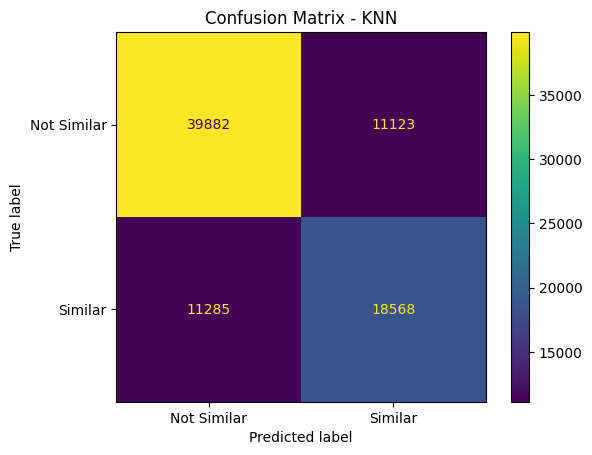

              precision    recall  f1-score   support

 Not Similar       0.78      0.78      0.78     51005
     Similar       0.63      0.62      0.62     29853

    accuracy                           0.72     80858
   macro avg       0.70      0.70      0.70     80858
weighted avg       0.72      0.72      0.72     80858

Accuracy: 0.723
Recall: 0.622
Precision: 0.625
F1-score: 0.624


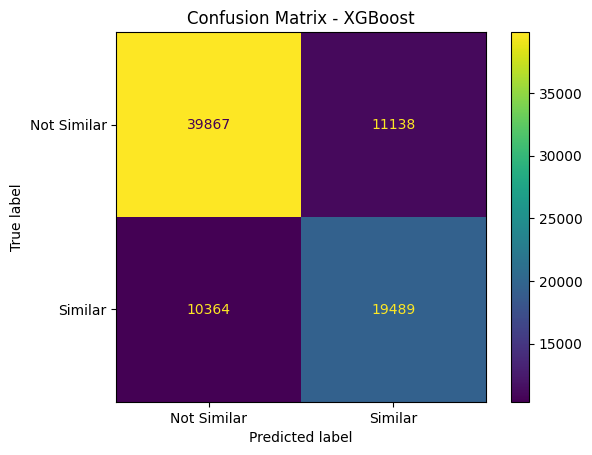

              precision    recall  f1-score   support

 Not Similar       0.79      0.78      0.79     51005
     Similar       0.64      0.65      0.64     29853

    accuracy                           0.73     80858
   macro avg       0.72      0.72      0.72     80858
weighted avg       0.74      0.73      0.73     80858

Accuracy: 0.734
Recall: 0.653
Precision: 0.636
F1-score: 0.644


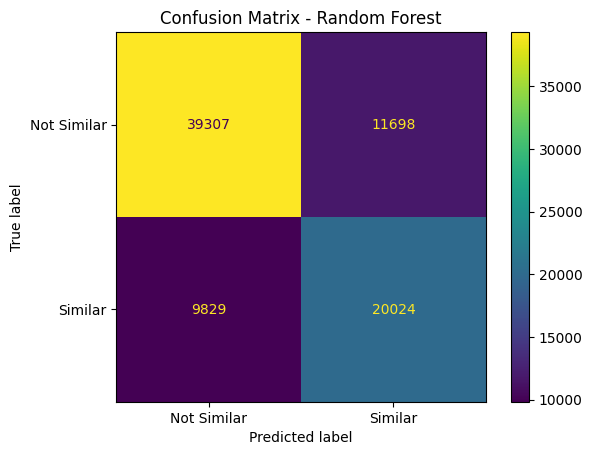

              precision    recall  f1-score   support

 Not Similar       0.80      0.77      0.79     51005
     Similar       0.63      0.67      0.65     29853

    accuracy                           0.73     80858
   macro avg       0.72      0.72      0.72     80858
weighted avg       0.74      0.73      0.74     80858

Accuracy: 0.734
Recall: 0.671
Precision: 0.631
F1-score: 0.65


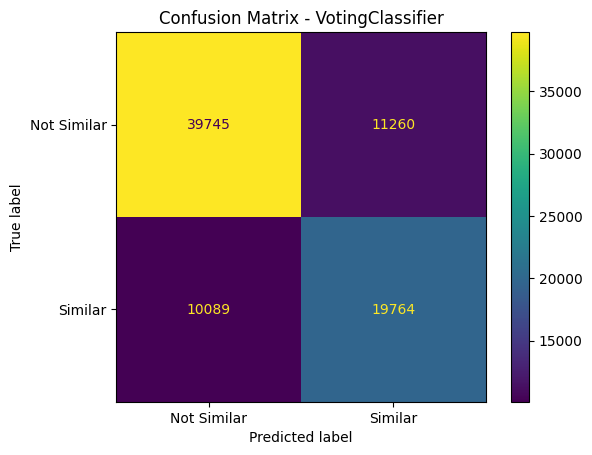

              precision    recall  f1-score   support

 Not Similar       0.80      0.78      0.79     51005
     Similar       0.64      0.66      0.65     29853

    accuracy                           0.74     80858
   macro avg       0.72      0.72      0.72     80858
weighted avg       0.74      0.74      0.74     80858

Accuracy: 0.736
Recall: 0.662
Precision: 0.637
F1-score: 0.649


In [21]:
models = {
    "KNN": loaded_best_knn,
    "XGBoost": loaded_best_xgb,
    "Random Forest": loaded_best_rf,
    "VotingClassifier": voting_clf
}

labels = ["Not Similar", "Similar"]
res_dict = {}

for name, model in models.items():
    predicted_labels = model.predict(X_test_with_fuzz)
    metric_dict = get_model_evaluation(y_test_with_fuzz, predicted_labels, labels, name)
    res_dict[name] = metric_dict

Overview of traditional ML models. VotingClassifier seems to be the best in general.

In [22]:
pd.DataFrame(res_dict)

,KNN,XGBoost,Random Forest,VotingClassifier
accuracy,0.723,0.734,0.734,0.736
recall,0.622,0.653,0.671,0.662
precision,0.625,0.636,0.631,0.637
f1,0.624,0.644,0.650,0.649


Conclusion:
- Even though dataset is slightly imbalanced (3:2 ratio), the imbalance is not causing a huge problem because we see that the ratio of FP and FN is about the same. We could explore balancing out the dataset but that is not of highest priority.
- Curse of dimensionality is also unlikely to greatly affect KNN's performance because it's performance is comparable to the ensemble methods and number of features is already less than 10 which is very reasonable.
- The bigger problem here is that they are unable to capture positioning and semantic meaning of text. Hence, we propose using more advanced techniques such as LSTM and transformers which have the ability to encode positioning and semantic meaning of text as numerical features. (source code in separate jupyter notebooks).

## Follow up from conclusion (extra stuff that we did for exploration)
### Exploring the effect of PCA on KNN

n_components = 3 because that is the elbow of the plot. Performance did not turn out as well where accuracy of KNN dropped from 72.3% to 70.5%. Using same set of hyperparameters for fair comparison.

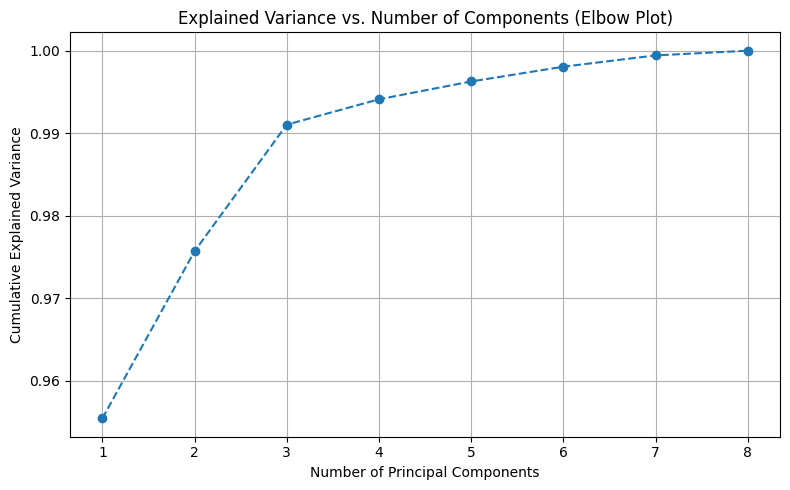

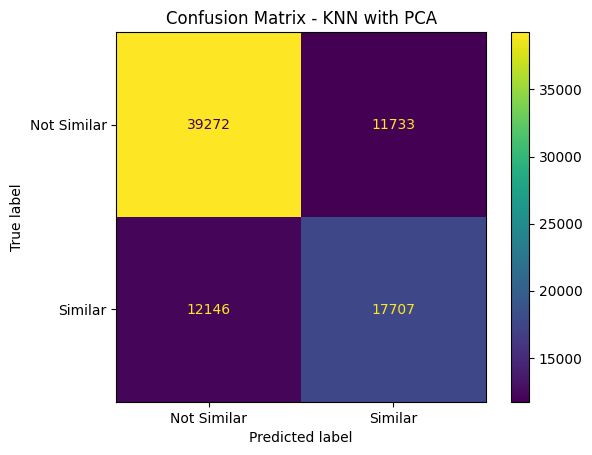

              precision    recall  f1-score   support

 Not Similar       0.76      0.77      0.77     51005
     Similar       0.60      0.59      0.60     29853

    accuracy                           0.70     80858
   macro avg       0.68      0.68      0.68     80858
weighted avg       0.70      0.70      0.70     80858

Accuracy: 0.705
Recall: 0.593
Precision: 0.601
F1-score: 0.597


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

with open("models/knn_best_params.json", "r") as f:
    loaded_best_knn_params = json.load(f)

loaded_best_knn_pca = KNeighborsClassifier(**loaded_best_knn_params)

scaler = StandardScaler()
pca = PCA()
pca.fit(X_train_with_fuzz)
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumsum_variance) + 1), cumsum_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components (Elbow Plot)')
plt.grid(True)
plt.tight_layout()
plt.show()

pca = PCA(n_components = 3)
X_train_pca = pca.fit_transform(X_train_with_fuzz)
X_test_pca = pca.transform(X_test_with_fuzz)

loaded_best_knn_pca.fit(X_train_pca, y_train_with_fuzz)
y_pred = loaded_best_knn_pca.predict(X_test_pca)

labels = ["Not Similar", "Similar"]
loaded_best_knn_pca_metrics = get_model_evaluation(y_test_with_fuzz, y_pred, labels, 'KNN with PCA')

### Exploring the effect of undersampling to balance out the dataset
Using same set of hyperparameters for fair comparison. There was an overall deprovement in accuracy but improvement in f1 score. We noticed that the precision went down because the model is likely to predict more positives now, resulting in a higher likelihood of false positives. Since the model is more likely to predict positive now and hence less likely to predict negative, we might see more true positives and because the model predicts fewer false negatives, causing recall to increase sharply.

Undersampling was chosen initially because we noticed that there was some form of overfitting through the training and exploration process and hence, removing some data points might help with it. 

Undersampling here causes accuracy to decrease because the model was previously biased towards the majority class which made the prediction of test points biased towards the majority class (the test set is also imbalanced). Hence, a fall in accuracy here does not really mean that the model performed worse because the better accuracy originally was a result of biased-ness in prediction.

However, in terms of f1-score, balancing the dataset helped to reduce biased-ness in terms of class prediction which should generally improve f1-score.

Judging based on the metrics, I would say the model is better with undersampling. We can also explore SMOTE.

Before resampling
<table>
    <tr>
        <th>Metric</th>
        <th>KNN</th>
        <th>XGB</th>
        <th>RF</th>
        <th>VC</th>
    </tr>
    <tr>
        <th>Accuracy</th>
        <th>0.723</th>
        <th>0.734</th>
        <th>0.734</th>
        <th>0.736</th>
    </tr>
    <tr>
        <th>Recall</th>
        <th>0.622</th>
        <th>0.653</th>
        <th>0.671</th>
        <th>0.662</th>
    </tr>
    <tr>
        <th>Precision</th>
        <th>0.625</th>
        <th>0.636</th>
        <th>0.631</th>
        <th>0.637</th>
    </tr>
    <tr>
        <th>F1</th>
        <th>0.624</th>
        <th>0.644</th>
        <th>0.650</th>
        <th>0.649</th>
    </tr>
</table>

After resampling
<table>
    <tr>
        <th>Metric</th>
        <th>KNN</th>
        <th>XGB</th>
        <th>RF</th>
        <th>VC</th>
    </tr>
    <tr>
        <th>Accuracy</th>
        <th>0.709</th>
        <th>0.715</th>
        <th>0.710</th>
        <th>0.714</th>
    </tr>
    <tr>
        <th>Recall</th>
        <th>0.807</th>
        <th>0.845</th>
        <th>0.870</th>
        <th>0.714</th>
    </tr>
    <tr>
        <th>Precision</th>
        <th>0.575</th>
        <th>0.578</th>
        <th>0.571</th>
        <th>0.576</th>
    </tr>
    <tr>
        <th>F1</th>
        <th>0.672</th>
        <th>0.686</th>
        <th>0.689</th>
        <th>0.689</th>
    </tr>
</table>

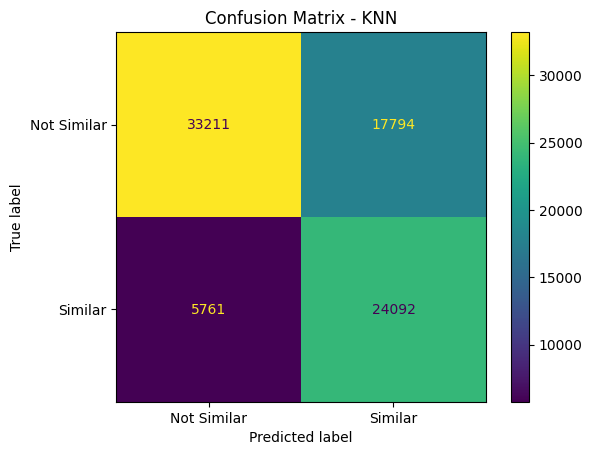

              precision    recall  f1-score   support

 Not Similar       0.85      0.65      0.74     51005
     Similar       0.58      0.81      0.67     29853

    accuracy                           0.71     80858
   macro avg       0.71      0.73      0.70     80858
weighted avg       0.75      0.71      0.71     80858

Accuracy: 0.709
Recall: 0.807
Precision: 0.575
F1-score: 0.672


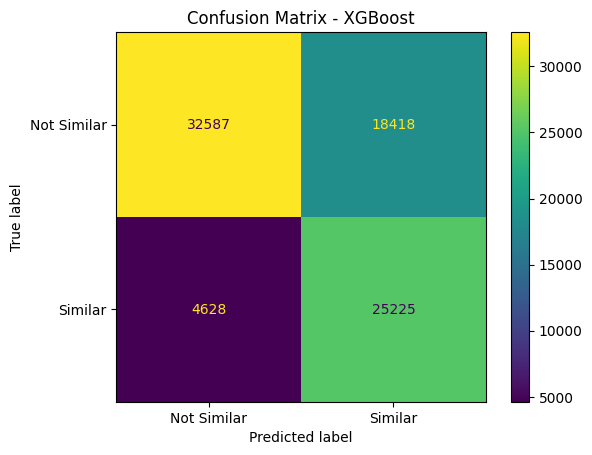

              precision    recall  f1-score   support

 Not Similar       0.88      0.64      0.74     51005
     Similar       0.58      0.84      0.69     29853

    accuracy                           0.71     80858
   macro avg       0.73      0.74      0.71     80858
weighted avg       0.77      0.71      0.72     80858

Accuracy: 0.715
Recall: 0.845
Precision: 0.578
F1-score: 0.686


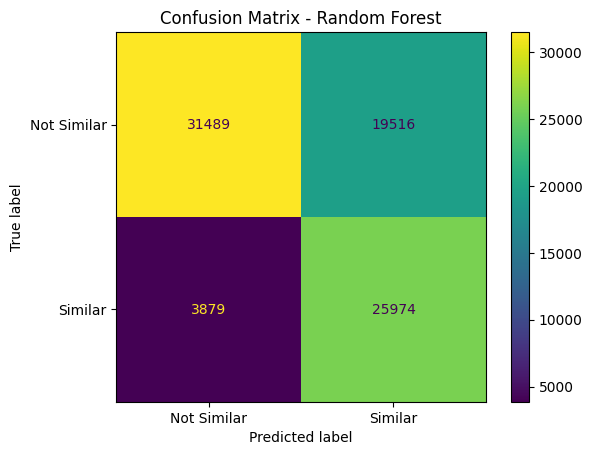

              precision    recall  f1-score   support

 Not Similar       0.89      0.62      0.73     51005
     Similar       0.57      0.87      0.69     29853

    accuracy                           0.71     80858
   macro avg       0.73      0.74      0.71     80858
weighted avg       0.77      0.71      0.71     80858

Accuracy: 0.711
Recall: 0.87
Precision: 0.571
F1-score: 0.689


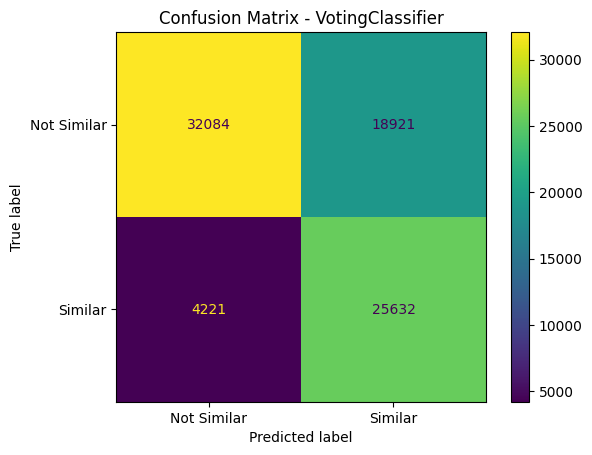

              precision    recall  f1-score   support

 Not Similar       0.88      0.63      0.73     51005
     Similar       0.58      0.86      0.69     29853

    accuracy                           0.71     80858
   macro avg       0.73      0.74      0.71     80858
weighted avg       0.77      0.71      0.72     80858

Accuracy: 0.714
Recall: 0.859
Precision: 0.575
F1-score: 0.689


,KNN,XGBoost,Random Forest,VotingClassifier
accuracy,0.709,0.715,0.711,0.714
recall,0.807,0.845,0.870,0.859
precision,0.575,0.578,0.571,0.575
f1,0.672,0.686,0.689,0.689


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train_with_fuzz, y_train_with_fuzz)
with open("models/knn_best_params.json", "r") as f:
    loaded_best_knn_params = json.load(f)

with open("models/xgb_best_params.json", "r") as f:
    loaded_best_xgb_params = json.load(f)

with open("models/rf_best_params.json", "r") as f:
    loaded_best_rf_params = json.load(f)

loaded_best_knn_resampled = KNeighborsClassifier(**loaded_best_knn_params)
loaded_best_xgb_resampled = XGBClassifier(**loaded_best_xgb_params)
loaded_best_rf_resampled = RandomForestClassifier(**loaded_best_rf_params)

voting_clf_resampled = VotingClassifier(
    estimators=[
        ('knn', loaded_best_knn_resampled),
        ('xgb', loaded_best_xgb_resampled),
        ('rf', loaded_best_rf_resampled)
    ],
    voting='hard'
)

loaded_best_knn_resampled.fit(X_resampled, y_resampled)
loaded_best_xgb_resampled.fit(X_resampled, y_resampled)
loaded_best_rf_resampled.fit(X_resampled, y_resampled)
voting_clf_resampled.fit(X_resampled, y_resampled)

models_resampled = {
    "KNN": loaded_best_knn_resampled,
    "XGBoost": loaded_best_xgb_resampled,
    "Random Forest": loaded_best_rf_resampled,
    "VotingClassifier": voting_clf_resampled
}

labels = ["Not Similar", "Similar"]
res_dict_resampled = {}

for name, model in models_resampled.items():
    predicted_labels = model.predict(X_test_with_fuzz)
    metric_dict = get_model_evaluation(y_test_with_fuzz, predicted_labels, labels, name)
    res_dict_resampled[name] = metric_dict

pd.DataFrame(res_dict_resampled)


### Exploring the effect of SMOTE

We notice that accuracy decreased slightly (much better than undersampling) and f1-score went up, suggesting that SMOTE is better for addressing the data imbalance. The explanation for accuracy, precision, recall and f1 is the same for undersampling. SMOTE is better than undersampling likely due to the fact that we have more data points.

Before resampling
<table>
    <tr>
        <th>Metric</th>
        <th>KNN</th>
        <th>XGB</th>
        <th>RF</th>
        <th>VC</th>
    </tr>
    <tr>
        <th>Accuracy</th>
        <th>0.723</th>
        <th>0.734</th>
        <th>0.734</th>
        <th>0.736</th>
    </tr>
    <tr>
        <th>Recall</th>
        <th>0.622</th>
        <th>0.653</th>
        <th>0.671</th>
        <th>0.662</th>
    </tr>
    <tr>
        <th>Precision</th>
        <th>0.625</th>
        <th>0.636</th>
        <th>0.631</th>
        <th>0.637</th>
    </tr>
    <tr>
        <th>F1</th>
        <th>0.624</th>
        <th>0.644</th>
        <th>0.650</th>
        <th>0.649</th>
    </tr>
</table>

After resampling
<table>
    <tr>
        <th>Metric</th>
        <th>KNN</th>
        <th>XGB</th>
        <th>RF</th>
        <th>VC</th>
    </tr>
    <tr>
        <th>Accuracy</th>
        <th>0.709</th>
        <th>0.729</th>
        <th>0.716</th>
        <th>0.724</th>
    </tr>
    <tr>
        <th>Recall</th>
        <th>0.794</th>
        <th>0.744</th>
        <th>0.842</th>
        <th>0.814</th>
    </tr>
    <tr>
        <th>Precision</th>
        <th>0.577</th>
        <th>0.608</th>
        <th>0.579</th>
        <th>0.592</th>
    </tr>
    <tr>
        <th>F1</th>
        <th>0.668</th>
        <th>0.669</th>
        <th>0.686</th>
        <th>0.685</th>
    </tr>
</table>

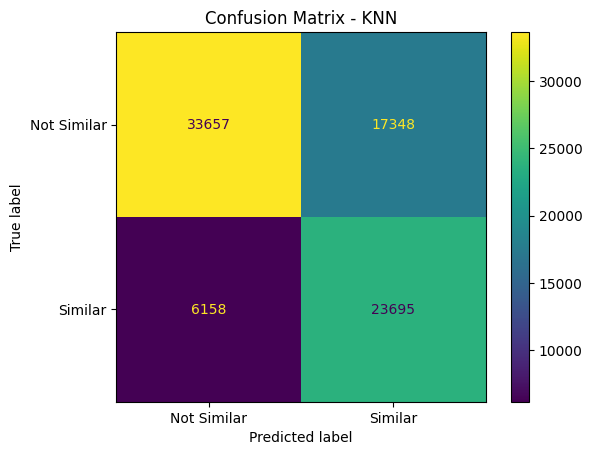

              precision    recall  f1-score   support

 Not Similar       0.85      0.66      0.74     51005
     Similar       0.58      0.79      0.67     29853

    accuracy                           0.71     80858
   macro avg       0.71      0.73      0.70     80858
weighted avg       0.75      0.71      0.71     80858

Accuracy: 0.709
Recall: 0.794
Precision: 0.577
F1-score: 0.668


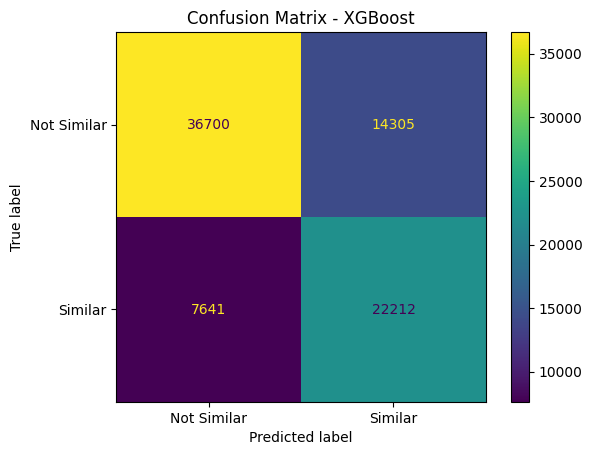

              precision    recall  f1-score   support

 Not Similar       0.83      0.72      0.77     51005
     Similar       0.61      0.74      0.67     29853

    accuracy                           0.73     80858
   macro avg       0.72      0.73      0.72     80858
weighted avg       0.75      0.73      0.73     80858

Accuracy: 0.729
Recall: 0.744
Precision: 0.608
F1-score: 0.669


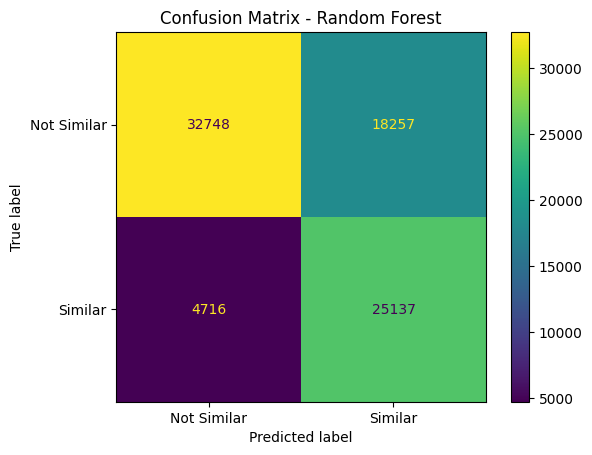

              precision    recall  f1-score   support

 Not Similar       0.87      0.64      0.74     51005
     Similar       0.58      0.84      0.69     29853

    accuracy                           0.72     80858
   macro avg       0.73      0.74      0.71     80858
weighted avg       0.77      0.72      0.72     80858

Accuracy: 0.716
Recall: 0.842
Precision: 0.579
F1-score: 0.686


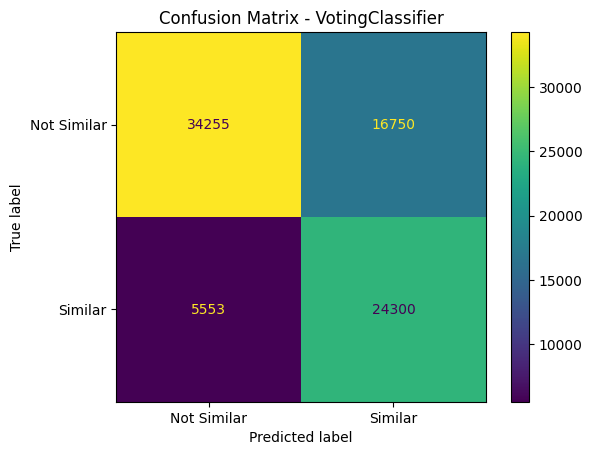

              precision    recall  f1-score   support

 Not Similar       0.86      0.67      0.75     51005
     Similar       0.59      0.81      0.69     29853

    accuracy                           0.72     80858
   macro avg       0.73      0.74      0.72     80858
weighted avg       0.76      0.72      0.73     80858

Accuracy: 0.724
Recall: 0.814
Precision: 0.592
F1-score: 0.685


,KNN,XGBoost,Random Forest,VotingClassifier
accuracy,0.709,0.729,0.716,0.724
recall,0.794,0.744,0.842,0.814
precision,0.577,0.608,0.579,0.592
f1,0.668,0.669,0.686,0.685


In [26]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_with_fuzz, y_train_with_fuzz)

with open("models/knn_best_params.json", "r") as f:
    loaded_best_knn_params = json.load(f)

with open("models/xgb_best_params.json", "r") as f:
    loaded_best_xgb_params = json.load(f)

with open("models/rf_best_params.json", "r") as f:
    loaded_best_rf_params = json.load(f)

loaded_best_knn_smote = KNeighborsClassifier(**loaded_best_knn_params)
loaded_best_xgb_smote = XGBClassifier(**loaded_best_xgb_params)
loaded_best_rf_smote = RandomForestClassifier(**loaded_best_rf_params)

voting_clf_smote = VotingClassifier(
    estimators=[
        ('knn', loaded_best_knn_smote),
        ('xgb', loaded_best_xgb_smote),
        ('rf', loaded_best_rf_smote)
    ],
    voting='hard'
)

loaded_best_knn_smote.fit(X_smote, y_smote)
loaded_best_xgb_smote.fit(X_smote, y_smote)
loaded_best_rf_smote.fit(X_smote, y_smote)
voting_clf_smote.fit(X_smote, y_smote)

models_resampled = {
    "KNN": loaded_best_knn_smote,
    "XGBoost": loaded_best_xgb_smote,
    "Random Forest": loaded_best_rf_smote,
    "VotingClassifier": voting_clf_smote
}

labels = ["Not Similar", "Similar"]
res_dict_smote = {}

for name, model in models_resampled.items():
    predicted_labels = model.predict(X_test_with_fuzz)
    metric_dict = get_model_evaluation(y_test_with_fuzz, predicted_labels, labels, name)
    res_dict_smote[name] = metric_dict

pd.DataFrame(res_dict_smote)